In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Data Mining/Project

/content/drive/MyDrive/Colab Notebooks/Data Mining/Project


In [15]:
!pip3 install tensorflow wordnet nltk

In [6]:
import pandas as pd
import chardet

# Define a function to detect the encoding of the file
def detect_encoding(file_path):
    with open(file_path, 'rb') as rawdata:
        result = chardet.detect(rawdata.read())
    return result['encoding']


In [7]:

# Define a function to parse the text file and extract relevant information
def parse_text_file(file_path):
    encoding = detect_encoding(file_path)
    data = []
    current_review = {}

    with open(file_path, 'r', encoding=encoding, errors='replace') as file:
        for line in file:
            line = line.strip()
            if line.startswith("review/text:"):
                current_review["review"] = line.split(":")[1].strip()
                data.append(current_review.copy())
                current_review = {}
            elif line.startswith("review/score:"):
                current_review["rating"] = float(line.split(":")[1].strip())
    return data


In [8]:
# Load the data from the text file with detected encoding
file_path = 'movie_reviews.txt'  # Replace with the path to your text file
data = parse_text_file(file_path)

# Create a DataFrame from the parsed data
df = pd.DataFrame(data)

# Optionally, you can save the DataFrame to a CSV file for future use
df.to_csv('movie_reviews.csv', index=False)

In [3]:
import pandas as pd
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [10]:
# Load the dataset
file_path = 'movie_reviews.csv'  # Replace with your file path
movie_reviews = pd.read_csv(file_path)

In [11]:
# Data Cleaning and Validation
# Removing duplicates
movie_reviews.drop_duplicates(subset=['review'], inplace=True)

# Handling missing values
movie_reviews.dropna(subset=['review'], inplace=True)

In [12]:
# Function to clean the review text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

# Apply the cleaning function to the review column
movie_reviews['cleaned_review'] = movie_reviews['review'].apply(clean_text)


In [13]:
def get_pos_tag(tag):
    """ Returns the part-of-speech tag for use with WordNetLemmatizer. """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN for


In [17]:
import string
# Advanced Preprocessing
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()
en_stops = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized = []
    for token, tag in pos_tag(tokens):
        if token.lower() not in en_stops and token not in string.punctuation:
            lemma = lemmatizer.lemmatize(token, pos=get_pos_tag(tag))
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Applying the preprocessing to each review
movie_reviews['processed_review'] = movie_reviews['cleaned_review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


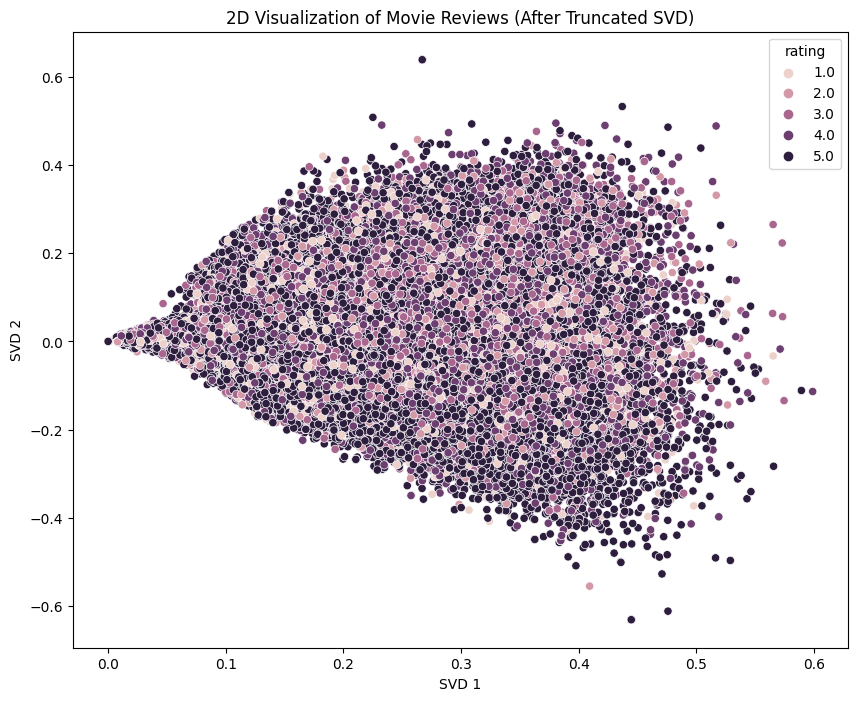

In [18]:
# Feature Extraction and Dimensionality Reduction
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(movie_reviews['processed_review'])

svd = TruncatedSVD(n_components=100)  # Adjust 'n_components' as needed
X_reduced = svd.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=movie_reviews['rating'])
plt.title('2D Visualization of Movie Reviews (After Truncated SVD)')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, movie_reviews['rating'], test_size=0.2, random_state=42)

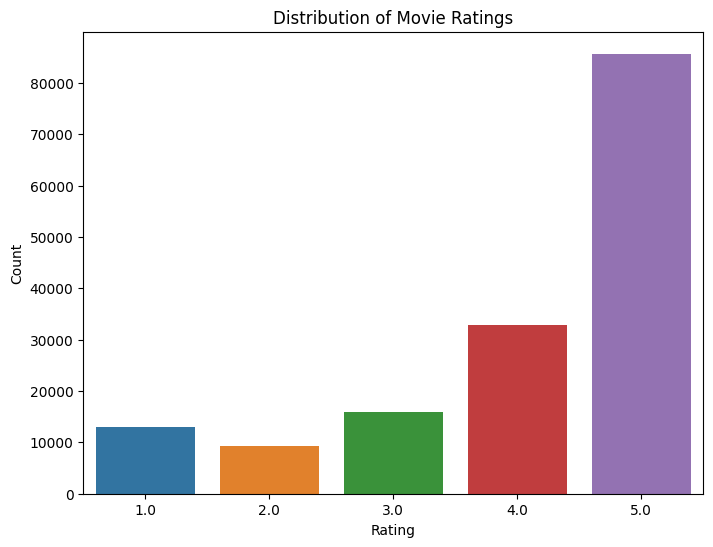

In [19]:
# Additional Visualization 1: Rating Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x=movie_reviews['rating'])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [20]:
# Train the RandomForestClassifier directly on the transformed data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
rf_y_pred = model.predict(X_test)


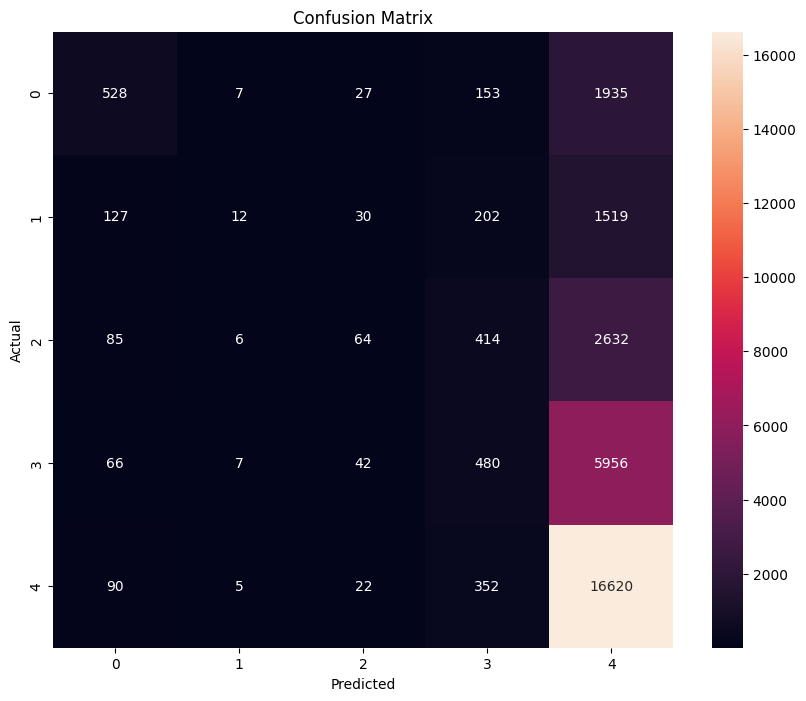

0.5641630285841751


In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
# Additional Visualization 2: Confusion Matrix
cm = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(rf_accuracy)

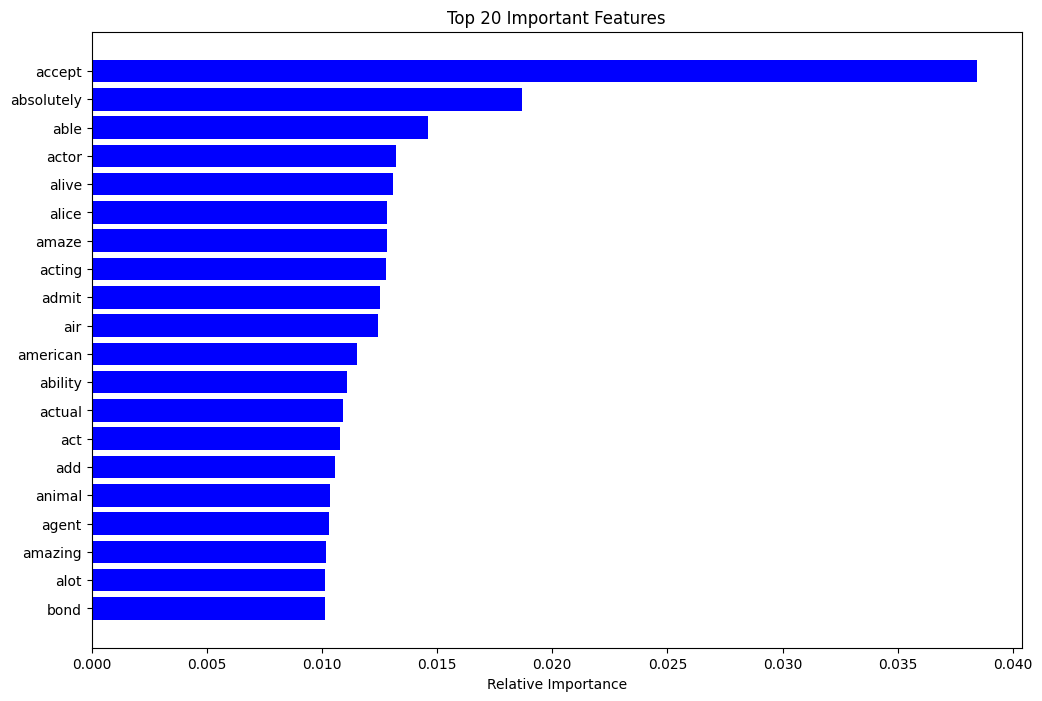

In [22]:

# Additional Visualization 3: Feature Importance (Random Forest)
# Extracting feature importance
feature_importances = model.feature_importances_
top_n = 20  # Top n features
# Ensure 'tfidf' is the original TF-IDF vectorizer used before dimensionality reduction
features = tfidf.get_feature_names_out()
indices = np.argsort(feature_importances)[-top_n:]


plt.figure(figsize=(12, 8))
plt.title('Top 20 Important Features')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [23]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.585131130301775


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Train MultinomialNB on the scaled data
nb_model = MultinomialNB()
nb_model.fit(X_train_scaled, y_train)

# Predict and evaluate as usual
y_pred_nb = nb_model.predict(X_test_scaled)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy}")


Naive Bayes Accuracy: 0.5445651827538956


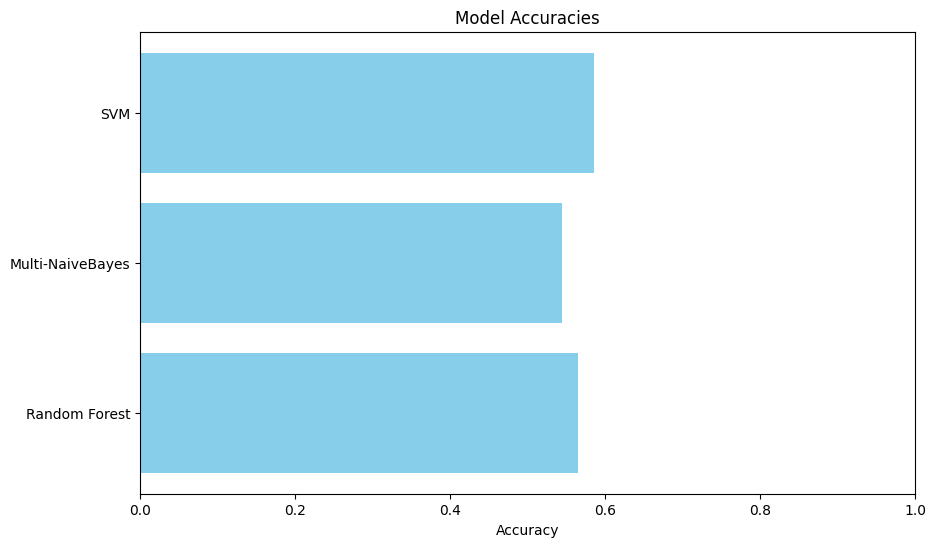

In [26]:
model_names=["SVM", "Multi-NaiveBayes", "Random Forest"]
accuracies=[svm_accuracy,nb_accuracy,rf_accuracy]
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0, 1)  # Set the x-axis limits to represent accuracy between 0 and 1
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest accuracy at the top
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your dataset split into X_train, X_test, y_train, and y_test

# Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
lr_y_pred = logistic_model.predict(X_test)


In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
rfr_y_pred = rfr.predict(X_test)


In [29]:
# Calculate MSE
lr_mse = mean_squared_error(y_test, lr_y_pred)
rfr_mse = mean_squared_error(y_test, rfr_y_pred)

print(f"MSE for Logistic Regression: {lr_mse}")
print(f"MSE for Random Forest Regressor: {rfr_mse}")

MSE for Logistic Regression: 1.8316178579395175
MSE for Random Forest Regressor: 1.2555523320359872


In [ ]:
model_names=["RandomForestRegressor", "Logistic Regression"]
mse=[rfr_mse,lr_mse]
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='red')
plt.xlabel('MSE')
plt.title('Models MSE')
plt.xlim(0, 1)  # Set the x-axis limits to represent accuracy between 0 and 1
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest accuracy at the top
plt.show()

In [30]:
### Finalized Model

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import string

# Load the movie reviews dataset
reviews_path = 'movie_reviews.csv'
movie_reviews = pd.read_csv(reviews_path)

# Function to clean the review text
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string inputs
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

# Function for part-of-speech tagging
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN

# Preprocess text
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
en_stops = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized = []
    for token, tag in nltk.pos_tag(tokens):
        if token.lower() not in en_stops and token not in string.punctuation:
            lemma = lemmatizer.lemmatize(token, pos=get_pos_tag(tag))
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Applying preprocessing
movie_reviews['cleaned_review'] = movie_reviews['review'].apply(clean_text)
movie_reviews['processed_review'] = movie_reviews['cleaned_review'].apply(preprocess_text)

# Feature Extraction
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(movie_reviews['processed_review'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)

# Splitting the dataset
y = movie_reviews['rating']
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Training the RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# Predicting and evaluating
y_pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.036553619570436

In [8]:
import pickle

# Save the model to a file
with open('random_forest_regressor_model.pkl', 'wb') as file:
    pickle.dump(rfr, file)





In [10]:
# Recreate the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(movie_reviews['processed_review'])

# Save the TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)



In [11]:
svd_transformer = TruncatedSVD(n_components=100)
svd_features = svd_transformer.fit_transform(tfidf_features)


with open('svd_transformer.pkl', 'wb') as file:
    pickle.dump(svd_transformer, file)

In [13]:
# print('hi')
import os

try:

    import sys
    import pickle
    import re
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    import joblib



    # Load the saved models
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        tfidf_vectorizer = pickle.load(file)

    with open('svd_transformer.pkl', 'rb') as file:
        svd_transformer = pickle.load(file)

    with open('random_forest_regressor_model.pkl', 'rb') as file:
        random_forest_model = pickle.load(file)

    # Function to clean text
    def clean_text(text):
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove non-letters
        text = text.lower().strip()  # Lowercase and strip whitespace
        return text

    # Function to preprocess text
    def preprocess_text(text, lemmatizer, stopwords):
        tokens = word_tokenize(text)
        lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
        return ' '.join(lemmatized)

    # Preprocess a new review
    def process_new_review(new_review):
        lemmatizer = WordNetLemmatizer()
        stopwords = set(nltk.corpus.stopwords.words('english'))

        cleaned_review = clean_text(new_review)
        processed_review = preprocess_text(cleaned_review, lemmatizer, stopwords)
        tfidf_review = tfidf_vectorizer.transform([processed_review])
        reduced_review = svd_transformer.transform(tfidf_review)

        return reduced_review

    # Predict the rating for a new review
    new_review = "Its a very good movie"
    processed_review = process_new_review(new_review)
    predicted_rating = random_forest_model.predict(processed_review)

    print(2*predicted_rating[0])

    # sys.path.append("locationOfScript/")
except Exception as e:
    print(e)

8.0706443001443
